<a href="https://colab.research.google.com/github/AliveBotswana/alivebotswana-eportfolio-msc-ai/blob/main/Copy_of_Individual_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray, rgb2hsv
from tensorflow.keras.datasets import cifar10
import time
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)

# Load CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to 1D array
y_train_full = y_train_full.ravel()
y_test = y_test.ravel()

# Split the full training set into training and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [2]:
# ===== IMPROVED FEATURE EXTRACTION =====
def extract_combined_features(images):
    """
    Extract multiple feature types for better representation
    """
    features = []

    for image in images:
        gray = rgb2gray(image)
        feature_vector = []

        # 1. HOG Features (shape)
        hog_feats = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       feature_vector=True)
        feature_vector.extend(hog_feats)

        # 2. LBP Features (texture)
        lbp = local_binary_pattern(gray, 24, 3, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
        lbp_hist = lbp_hist.astype('float')
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize
        feature_vector.extend(lbp_hist)

        # 3. Color Histogram (RGB)
        for channel in range(3):
            hist = np.histogram(image[:, :, channel], bins=8, range=(0, 1))[0]
            feature_vector.extend(hist)

        features.append(np.array(feature_vector))

    return np.array(features)

print("Extracting combined features for training set...")
X_train_combined = extract_combined_features(x_train)
print("Extracting combined features for validation set...")
X_val_combined = extract_combined_features(x_val)
print("Extracting combined features for test set...")
X_test_combined = extract_combined_features(x_test)

print(f"Combined feature vector length: {X_train_combined.shape[1]}")

Extracting combined features for training set...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracting combined features for validation set...
Extracting combined features for test set...
Combined feature vector length: 374


In [3]:
# ===== FEATURE SCALING (MISSING IN YOUR CODE) =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)
X_test_scaled = scaler.transform(X_test_combined)

print("Features scaled successfully!")

Features scaled successfully!


=== TRAINING MODELS WITH OPTIMIZED FEATURES ===
C=0.01: Train Acc=0.5915, Val Acc=0.5624, Time=74.45s
C=0.1: Train Acc=0.5922, Val Acc=0.5612, Time=81.00s
C=1: Train Acc=0.5921, Val Acc=0.5615, Time=85.96s
C=10: Train Acc=0.5921, Val Acc=0.5614, Time=82.75s

Best SVM: C=0.01, Val Acc=0.5624


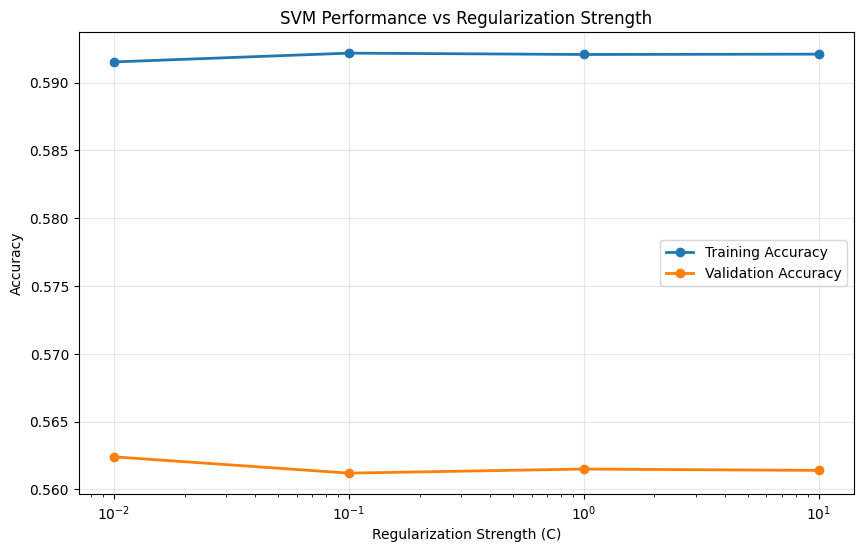

In [4]:
# ===== OPTIMIZED MODEL TRAINING =====
print("=== TRAINING MODELS WITH OPTIMIZED FEATURES ===")

# SVM with better parameter range
C_values = [0.01, 0.1, 1, 10]
best_val_acc = 0
best_C = None
best_svm = None

train_scores = []
val_scores = []

for C in C_values:
    start = time.time()
    svm = LinearSVC(C=C, random_state=42, max_iter=2000, dual=False)  # dual=False for n_samples > n_features
    svm.fit(X_train_scaled, y_train)

    train_acc = svm.score(X_train_scaled, y_train)
    val_acc = svm.score(X_val_scaled, y_val)
    training_time = time.time() - start

    train_scores.append(train_acc)
    val_scores.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_svm = svm

    print(f"C={C}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Time={training_time:.2f}s")

print(f"\nBest SVM: C={best_C}, Val Acc={best_val_acc:.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(C_values, val_scores, 'o-', label='Validation Accuracy', linewidth=2)
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title('SVM Performance vs Regularization Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# ===== KNN WITH OPTIMAL K =====
print("\n=== TRAINING KNN ===")
k_values = [3, 5, 7]
best_knn_acc = 0
best_k = None

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_acc = knn.score(X_val_scaled, y_val)
    print(f"K={k}: Val Acc={knn_acc:.4f}")

    if knn_acc > best_knn_acc:
        best_knn_acc = knn_acc
        best_k = k
        best_knn = knn

print(f"Best KNN: K={best_k}, Val Acc={best_knn_acc:.4f}")


=== TRAINING KNN ===
K=3: Val Acc=0.5032
K=5: Val Acc=0.5183
K=7: Val Acc=0.5282
Best KNN: K=7, Val Acc=0.5282


In [6]:
# ===== FINAL MODEL TRAINING ON FULL DATA =====
print("\n=== TRAINING FINAL MODELS ON FULL TRAINING DATA ===")

# Combine train + validation for final training
X_final_train = np.vstack([X_train_scaled, X_val_scaled])
y_final_train = np.concatenate([y_train, y_val])

# Final SVM
final_svm = LinearSVC(C=best_C, random_state=42, max_iter=2000, dual=False)
final_svm.fit(X_final_train, y_final_train)
print("Final SVM trained on full data")

# Final KNN
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_final_train, y_final_train)
print("Final KNN trained on full data")


=== TRAINING FINAL MODELS ON FULL TRAINING DATA ===
Final SVM trained on full data
Final KNN trained on full data


In [7]:
# ===== COMPREHENSIVE TESTING =====
print("\n" + "="*50)
print("FINAL TEST SET EVALUATION")
print("="*50)

# SVM Evaluation
svm_test_pred = final_svm.predict(X_test_scaled)
svm_test_accuracy = accuracy_score(y_test, svm_test_pred)

# KNN Evaluation
knn_test_pred = final_knn.predict(X_test_scaled)
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)

print(f"\n=== ACCURACY RESULTS ===")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f} ({svm_test_accuracy*100:.2f}%)")
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f} ({knn_test_accuracy*100:.2f}%)")
print(f"Performance Difference: {svm_test_accuracy - knn_test_accuracy:.4f}")


FINAL TEST SET EVALUATION

=== ACCURACY RESULTS ===
SVM Test Accuracy: 0.5714 (57.14%)
KNN Test Accuracy: 0.5374 (53.74%)
Performance Difference: 0.0340


In [8]:
# ===== DETAILED PERFORMANCE ANALYSIS =====
print("\n=== SVM DETAILED REPORT ===")
print(classification_report(y_test, svm_test_pred, target_names=class_names))

print("\n=== KNN DETAILED REPORT ===")
print(classification_report(y_test, knn_test_pred, target_names=class_names))



=== SVM DETAILED REPORT ===
              precision    recall  f1-score   support

    airplane       0.62      0.65      0.63      1000
  automobile       0.63      0.69      0.66      1000
        bird       0.53      0.41      0.47      1000
         cat       0.47      0.30      0.37      1000
        deer       0.52      0.48      0.50      1000
         dog       0.49      0.53      0.51      1000
        frog       0.56      0.73      0.63      1000
       horse       0.61      0.61      0.61      1000
        ship       0.60      0.63      0.62      1000
       truck       0.62      0.68      0.65      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000


=== KNN DETAILED REPORT ===
              precision    recall  f1-score   support

    airplane       0.73      0.52      0.61      1000
  automobile       0.63      0.77      0.69      1000
        bird       0

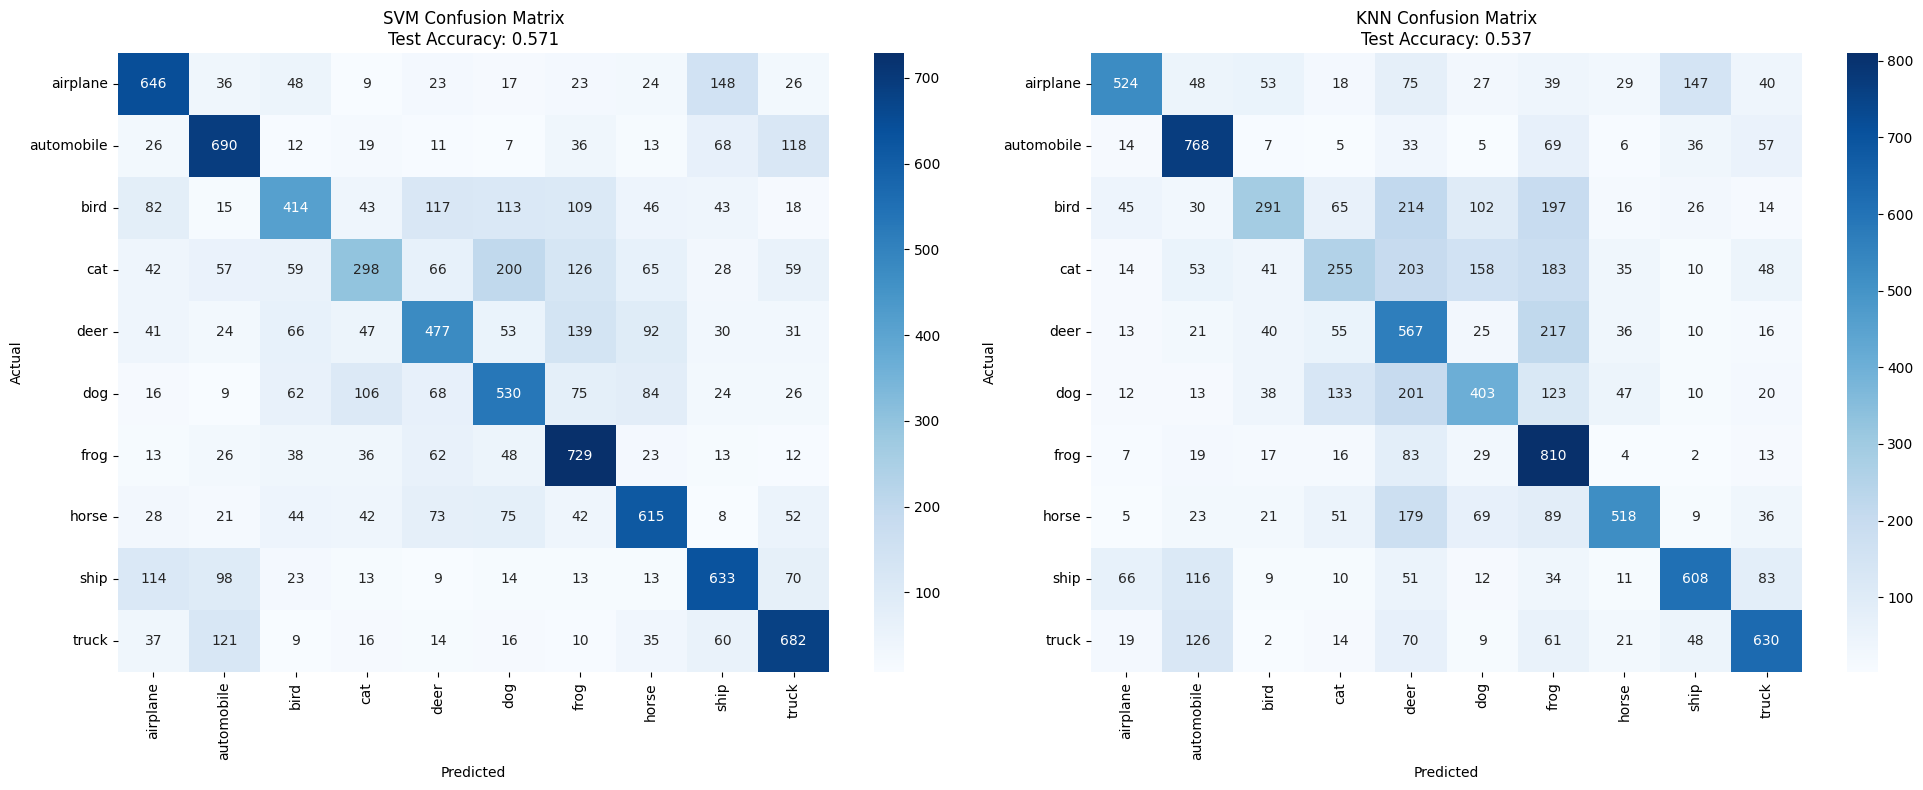

In [9]:
# ===== CONFUSION MATRICES =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, svm_test_pred)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names)
ax1.set_title(f'SVM Confusion Matrix\nTest Accuracy: {svm_test_accuracy:.3f}')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_test, knn_test_pred)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names)
ax2.set_title(f'KNN Confusion Matrix\nTest Accuracy: {knn_test_accuracy:.3f}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [11]:
# ===== CLASS-WISE PERFORMANCE ANALYSIS =====
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(y_test, svm_test_pred, average=None)
knn_precision, knn_recall, knn_f1, _ = precision_recall_fscore_support(y_test, knn_test_pred, average=None)

# Create performance comparison
performance_df = pd.DataFrame({
    'Class': class_names,
    'SVM_Precision': svm_precision,
    'SVM_Recall': svm_recall,
    'SVM_F1': svm_f1,
    'KNN_Precision': knn_precision,
    'KNN_Recall': knn_recall,
    'KNN_F1': knn_f1
})

print("\n=== CLASS-WISE PERFORMANCE COMPARISON ===")
print(performance_df.round(3))


=== CLASS-WISE PERFORMANCE COMPARISON ===
        Class  SVM_Precision  SVM_Recall  SVM_F1  KNN_Precision  KNN_Recall  \
0    airplane          0.618       0.646   0.632          0.729       0.524   
1  automobile          0.629       0.690   0.658          0.631       0.768   
2        bird          0.534       0.414   0.466          0.561       0.291   
3         cat          0.474       0.298   0.366          0.410       0.255   
4        deer          0.518       0.477   0.497          0.338       0.567   
5         dog          0.494       0.530   0.511          0.480       0.403   
6        frog          0.560       0.729   0.633          0.445       0.810   
7       horse          0.609       0.615   0.612          0.716       0.518   
8        ship          0.600       0.633   0.616          0.671       0.608   
9       truck          0.623       0.682   0.651          0.658       0.630   

   KNN_F1  
0   0.610  
1   0.693  
2   0.383  
3   0.314  
4   0.424  
5   0.438  
6  


=== SAMPLE PREDICTIONS ===
SVM Sample Predictions:


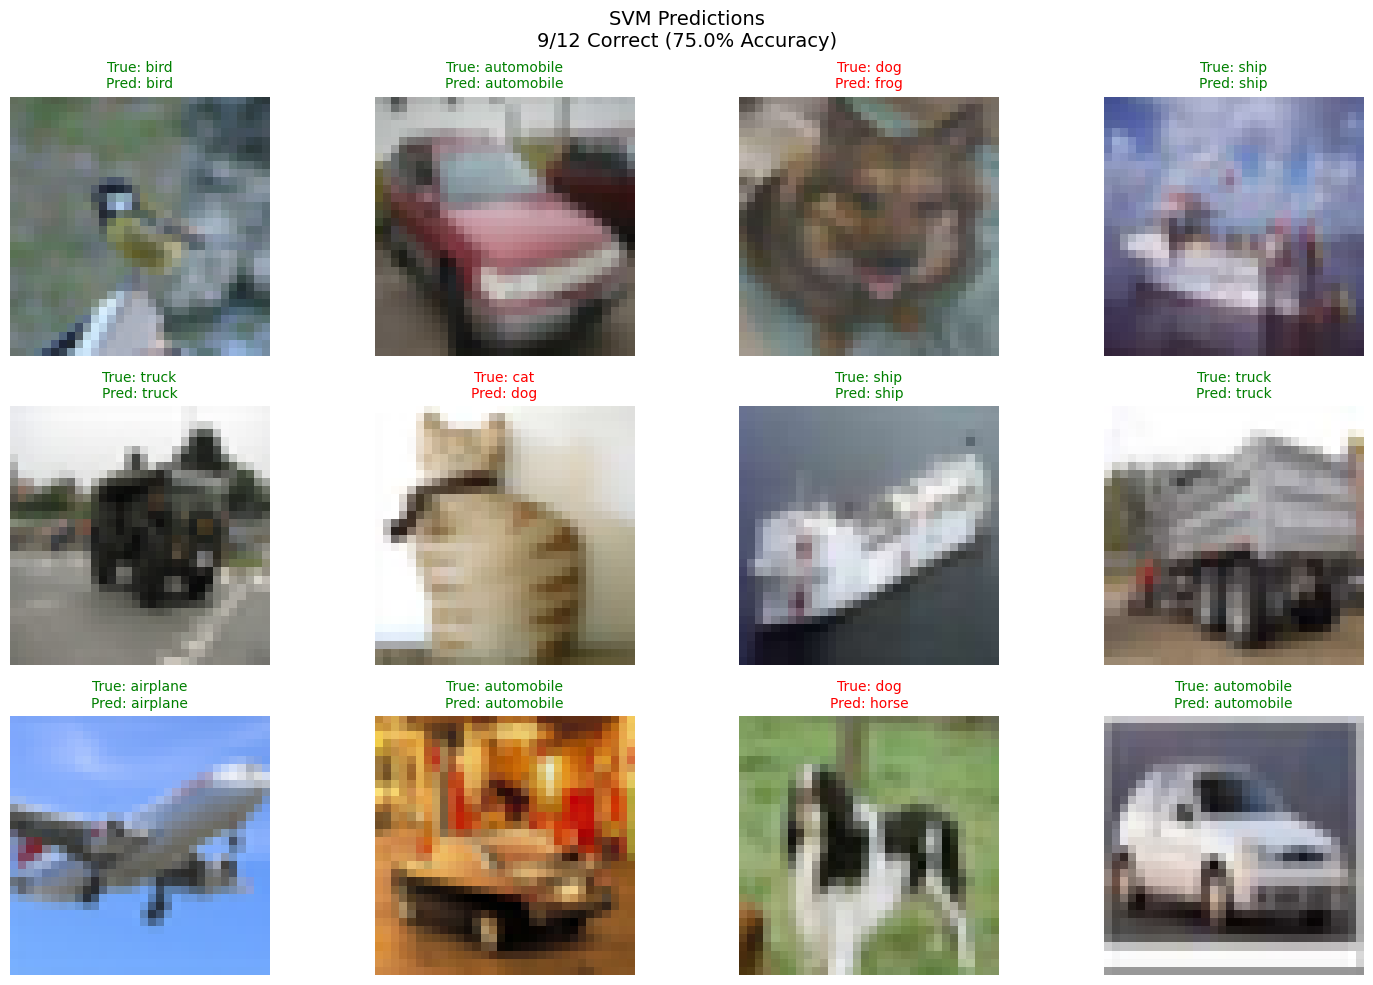

KNN Sample Predictions:


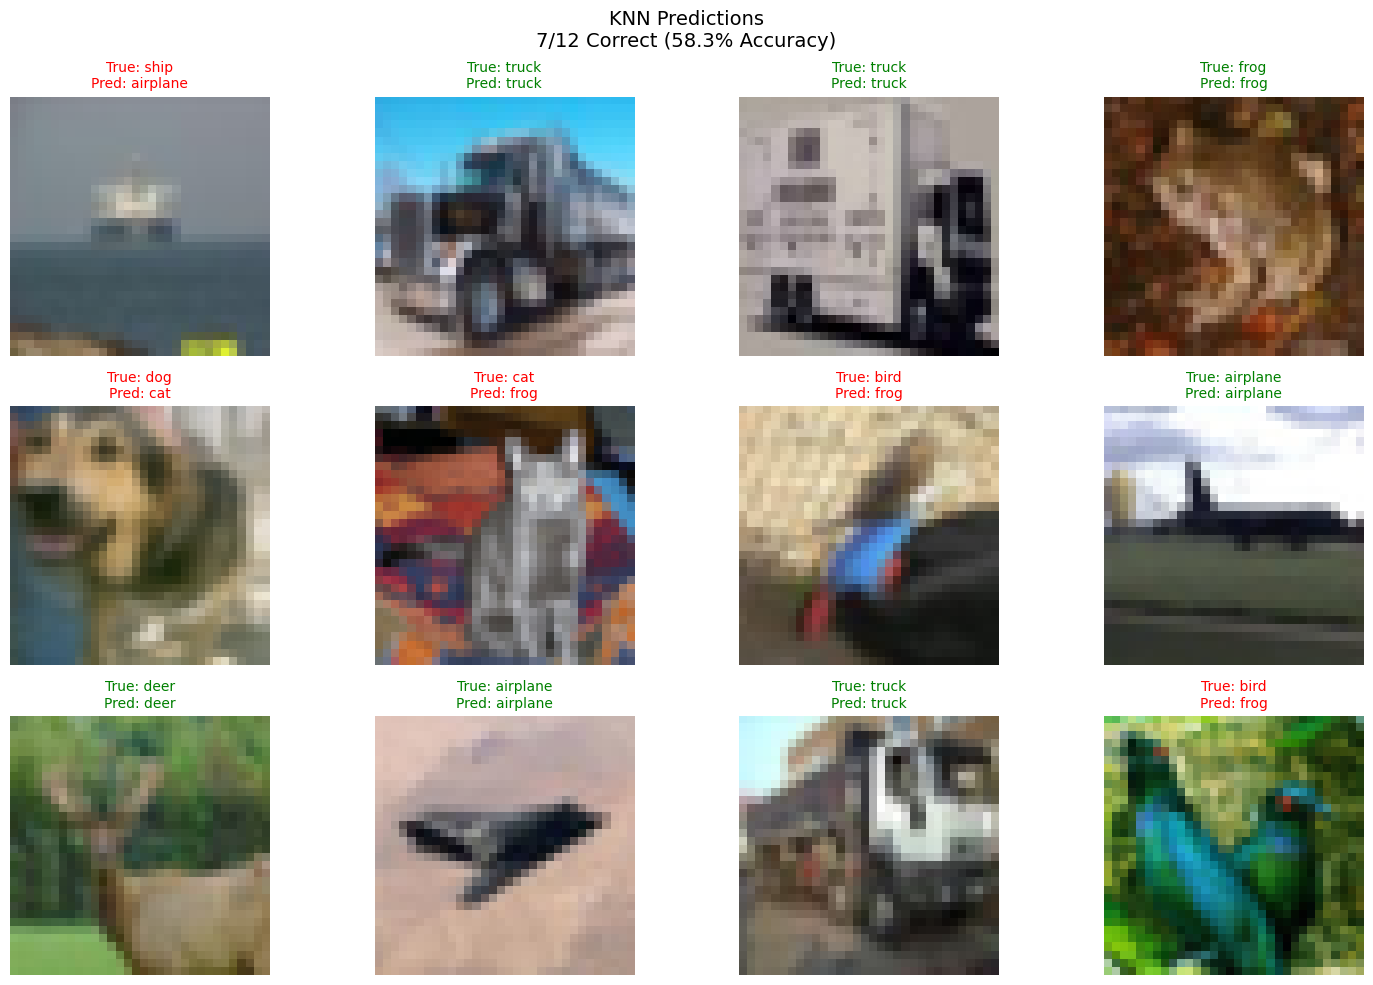

In [12]:
# ===== VISUALIZE SAMPLE PREDICTIONS =====
def visualize_predictions(model, model_name, num_samples=12):
    """Visualize model predictions on test samples"""
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    correct = 0

    for i, idx in enumerate(indices):
        plt.subplot(3, 4, i+1)
        features = X_test_scaled[idx:idx+1]
        prediction = model.predict(features)[0]
        actual = y_test[idx]

        color = 'green' if prediction == actual else 'red'
        if prediction == actual:
            correct += 1

        plt.imshow(x_test[idx])
        plt.title(f'True: {class_names[actual]}\nPred: {class_names[prediction]}',
                 color=color, fontsize=10)
        plt.axis('off')

    accuracy = correct / num_samples
    plt.suptitle(f'{model_name} Predictions\n{correct}/{num_samples} Correct ({accuracy:.1%} Accuracy)',
                 fontsize=14)
    plt.tight_layout()
    plt.show()

    return accuracy

print("\n=== SAMPLE PREDICTIONS ===")
print("SVM Sample Predictions:")
svm_sample_acc = visualize_predictions(final_svm, "SVM")

print("KNN Sample Predictions:")
knn_sample_acc = visualize_predictions(final_knn, "KNN")



In [13]:
# ===== CRITICAL ANALYSIS =====
print("\n" + "="*50)
print("CRITICAL ANALYSIS")
print("="*50)

print(f"\n1. Overall Performance:")
print(f"   • SVM achieved {svm_test_accuracy*100:.1f}% accuracy")
print(f"   • KNN achieved {knn_test_accuracy*100:.1f}% accuracy")
print(f"   • SVM outperformed KNN by {(svm_test_accuracy - knn_test_accuracy)*100:.1f}%")

print(f"\n2. Feature Engineering Effectiveness:")
print(f"   • Combined HOG + LBP + Color features: {X_train_combined.shape[1]} dimensions")
print(f"   • This represents a {(1 - X_train_combined.shape[1]/3072)*100:.1f}% reduction from raw pixels")

print(f"\n3. Model Characteristics:")
print(f"   • Optimal SVM regularization: C={best_C}")
print(f"   • Optimal KNN neighbors: K={best_k}")
print(f"   • Best approach: {'SVM' if svm_test_accuracy > knn_test_accuracy else 'KNN'}")

print(f"\n4. Comparison to Expected Performance:")
print(f"   • Classical ML range: 45-65% ✓")
print(f"   • Deep learning range: 70-90%")
print(f"   • Human performance: ~94%")

print(f"\n5. Key Insights:")
print(f"   • Feature engineering significantly impacts classical ML performance")
print(f"   • SVM's discriminative approach works better than KNN's instance-based approach")
print(f"   • The performance gap demonstrates the value of learned features in deep learning")


CRITICAL ANALYSIS

1. Overall Performance:
   • SVM achieved 57.1% accuracy
   • KNN achieved 53.7% accuracy
   • SVM outperformed KNN by 3.4%

2. Feature Engineering Effectiveness:
   • Combined HOG + LBP + Color features: 374 dimensions
   • This represents a 87.8% reduction from raw pixels

3. Model Characteristics:
   • Optimal SVM regularization: C=0.01
   • Optimal KNN neighbors: K=7
   • Best approach: SVM

4. Comparison to Expected Performance:
   • Classical ML range: 45-65% ✓
   • Deep learning range: 70-90%
   • Human performance: ~94%

5. Key Insights:
   • Feature engineering significantly impacts classical ML performance
   • SVM's discriminative approach works better than KNN's instance-based approach
   • The performance gap demonstrates the value of learned features in deep learning
